# Imports

In [183]:
import os
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import seaborn as sns
import numpy as np

In [2]:
# set credentials
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "../documents/key.json"
# creates a client
client = bigquery.Client()

# Loading Data

In [3]:
# References
ds_ref = client.dataset('cfpb_complaints', project='bigquery-public-data')
df_ref = ds_ref.table('complaint_database')
# API - request Fetch the table
df = client.get_table(df_ref)
df.schema

[SchemaField('date_received', 'DATE', 'NULLABLE', 'Date the complaint was received by the CPFB', (), None),
 SchemaField('product', 'STRING', 'NULLABLE', 'The type of product the consumer identified in the complaint', (), None),
 SchemaField('subproduct', 'STRING', 'NULLABLE', 'The type of sub-product the consumer identified in the complaint', (), None),
 SchemaField('issue', 'STRING', 'NULLABLE', 'The issue the consumer identified in the complaint', (), None),
 SchemaField('subissue', 'STRING', 'NULLABLE', 'The sub-issue the consumer identified in the complaint', (), None),
 SchemaField('consumer_complaint_narrative', 'STRING', 'NULLABLE', 'A description of the complaint provided by the consumer', (), None),
 SchemaField('company_public_response', 'STRING', 'NULLABLE', "The company's optional, public-facing response to a consumer's complaint", (), None),
 SchemaField('company_name', 'STRING', 'NULLABLE', 'Name of the company identified in the complaint by the consumer', (), None),
 Sc

In [4]:
client.list_rows(df, max_results=5).to_dataframe()

/home/caiomts/anaconda3/envs/financial-complaints/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1763: UserWarning: Cannot use bqstorage_client if max_results is set, reverting to fetching data with the REST endpoint.
  if not self._validate_bqstorage(bqstorage_client, create_bqstorage_client):


,date_received,product,subproduct,issue,subissue,consumer_complaint_narrative,company_public_response,company_name,state,zip_code,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,complaint_id
0,2020-06-29,"Money transfer, virtual currency, or money ser...",International money transfer,Fraud or scam,None,None,Company has responded to the consumer and the ...,"SANTANDER BANK, NATIONAL ASSOCIATION",NJ,07011,None,Consent withdrawn,Web,2020-06-29,Closed with explanation,True,None,3721484
1,2019-07-19,"Money transfer, virtual currency, or money ser...",Debt settlement,Fraud or scam,None,None,None,FREEDOM FINANCIAL NETWORK,CA,94561,Servicemember,Consent withdrawn,Web,2019-07-22,Closed with explanation,True,None,3311693
2,2019-10-16,"Money transfer, virtual currency, or money ser...",Mobile or digital wallet,Fraud or scam,None,None,None,"Paypal Holdings, Inc",WA,98107,None,Consent withdrawn,Web,2019-10-16,Closed with explanation,True,None,3407290
3,2018-04-10,"Money transfer, virtual currency, or money ser...",Domestic (US) money transfer,Fraud or scam,None,None,None,"Home Loan Center, Inc.",MD,20735,None,Consent withdrawn,Web,2018-04-16,Closed with explanation,True,None,2870698
4,2020-01-15,"Money transfer, virtual currency, or money ser...",Domestic (US) money transfer,Fraud or scam,None,None,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,FL,33326,None,Consent withdrawn,Web,2020-01-15,Closed with explanation,True,None,3496215


In [5]:
query = """
        SELECT date_received, product, subproduct, issue, company_name, 
        state, date_sent_to_company, company_response_to_consumer, timely_response, 
        complaint_id
        FROM `bigquery-public-data.cfpb_complaints.complaint_database`
        WHERE EXTRACT(YEAR FROM date_received) >= 2018 OR company_response_to_consumer = 'In progress'
        ORDER BY date_received DESC
        """

In [6]:
# setting limits
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)

In [7]:
query_job = client.query(query, job_config=safe_config)
# API request
raw_df = query_job.to_dataframe()
raw_df.head()

,date_received,product,subproduct,issue,company_name,state,date_sent_to_company,company_response_to_consumer,timely_response,complaint_id
0,2021-03-26,Debt collection,Auto debt,Written notification about debt,NAVY FEDERAL CREDIT UNION,NV,2021-03-26,In progress,True,4247708
1,2021-03-26,Debt collection,Other debt,Attempts to collect debt not owed,"HCFS Health Care Financial Services, Inc.",TX,2021-03-26,Closed with explanation,True,4250323
2,2021-03-26,Debt collection,I do not know,Attempts to collect debt not owed,"Medical Data Systems, Inc.",NC,2021-03-26,In progress,True,4248600
3,2021-03-26,Student loan,Federal student loan servicing,Dealing with your lender or servicer,AES/PHEAA,RI,2021-03-26,Closed with explanation,True,4246344
4,2021-03-26,Mortgage,Conventional home mortgage,Closing on a mortgage,NAVY FEDERAL CREDIT UNION,GA,2021-03-26,In progress,True,4248281


In [8]:
# Copy
backup_raw_df = raw_df.copy()

# Data Preparation

In [9]:
raw_df.describe()

,date_received,product,subproduct,issue,company_name,state,date_sent_to_company,company_response_to_consumer,timely_response,complaint_id
count,1082380,1082380,1082380,1082380,1082380,1054168,1082380,1082378,1082380,1082380
unique,1181,9,48,81,4675,62,1181,5,2,1082380
top,2021-01-05,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,2021-01-05,Closed with explanation,True,3116991
freq,2309,598370,591422,397817,177202,131806,2328,917676,1068012,1


In [10]:
raw_df.dtypes

date_received                   object
product                         object
subproduct                      object
issue                           object
company_name                    object
state                           object
date_sent_to_company            object
company_response_to_consumer    object
timely_response                   bool
complaint_id                    object
dtype: object

In [11]:
# adjusting the date format
dates = ['date_received', 'date_sent_to_company']
for date in dates:
    raw_df[date] = pd.to_datetime(raw_df[date], format='%Y-%m-%d')

In [12]:
raw_df.set_index('date_received', inplace=True)

In [13]:
raw_df.head()

,product,subproduct,issue,company_name,state,date_sent_to_company,company_response_to_consumer,timely_response,complaint_id
date_received,,,,,,,,,
2021-03-26,Debt collection,Auto debt,Written notification about debt,NAVY FEDERAL CREDIT UNION,NV,2021-03-26,In progress,True,4247708
2021-03-26,Debt collection,Other debt,Attempts to collect debt not owed,"HCFS Health Care Financial Services, Inc.",TX,2021-03-26,Closed with explanation,True,4250323
2021-03-26,Debt collection,I do not know,Attempts to collect debt not owed,"Medical Data Systems, Inc.",NC,2021-03-26,In progress,True,4248600
2021-03-26,Student loan,Federal student loan servicing,Dealing with your lender or servicer,AES/PHEAA,RI,2021-03-26,Closed with explanation,True,4246344
2021-03-26,Mortgage,Conventional home mortgage,Closing on a mortgage,NAVY FEDERAL CREDIT UNION,GA,2021-03-26,In progress,True,4248281


In [14]:
raw_df.company_response_to_consumer.unique()

array(['In progress', 'Closed with explanation',
       'Closed with non-monetary relief', 'Closed with monetary relief',
       'Untimely response', None], dtype=object)

# EDA

### 1 - Which companies have the most complaints?

In [15]:
comp_most_complaints = raw_df[['company_name', 'complaint_id']] \
.groupby('company_name').count().sort_values(by='complaint_id', ascending=False).head(20).index.to_list()

### 2 - Which companies have the most complaints this year?

In [16]:
comp_most_complaints_2021 = raw_df.loc['2021' , ['company_name', 'complaint_id']] \
.groupby('company_name').count().sort_values(by='complaint_id', ascending=False).head(20).index.to_list()

### 3 - Which companies have the most complaints 'in progress' or 'Untimely response'?

In [17]:
comp_most_complaints_unsolved = raw_df.loc[raw_df.company_response_to_consumer.isin(['In progress', 'Untimely response']),
           ['company_name', 'complaint_id']] \
.groupby('company_name').count().sort_values(by='complaint_id', ascending=False).head(20).index.to_list()

### 4 - What are the most recurring issues per company? 

In [18]:
comp_recurring_issue = raw_df[['company_name', 'issue', 'complaint_id']] \
.groupby(['issue', 'company_name']).count().sort_values(by='complaint_id', 
                                                        ascending=False).head(20).index \
.get_level_values('company_name').to_list()

In [19]:
potential_customers = list(set(comp_most_complaints) | 
                        set(comp_most_complaints_2021) |
                        set(comp_most_complaints_unsolved)|
                          set (comp_recurring_issue))
len(potential_customers)

31

In [20]:
potential_customers

['Colony Brands, Inc.',
 'Santander Consumer USA Holdings Inc.',
 'SYNCHRONY FINANCIAL',
 'JPMORGAN CHASE & CO.',
 'CAPITAL ONE FINANCIAL CORPORATION',
 'AES/PHEAA',
 'PNC Bank N.A.',
 'Chime Financial Inc',
 'TD BANK US HOLDING COMPANY',
 'PORTFOLIO RECOVERY ASSOCIATES INC',
 'Paypal Holdings, Inc',
 'Experian Information Solutions Inc.',
 'Navient Solutions, LLC.',
 'WELLS FARGO & COMPANY',
 'Coinbase, Inc.',
 'ENCORE CAPITAL GROUP INC.',
 'TRANSUNION INTERMEDIATE HOLDINGS, INC.',
 'Mobiloans, LLC',
 'EQUIFAX, INC.',
 'ALLY FINANCIAL INC.',
 'Ameritech Financial',
 'CITIBANK, N.A.',
 'Alliance Data Card Services',
 'AMERICAN EXPRESS COMPANY',
 'CITIZENS FINANCIAL GROUP, INC.',
 'BARCLAYS BANK DELAWARE',
 'U.S. BANCORP',
 'Premier\xa0Student\xa0Loan\xa0Center',
 'BANK OF AMERICA, NATIONAL ASSOCIATION',
 'DISCOVER BANK',
 'NAVY FEDERAL CREDIT UNION']

**The first step was to access large numbers. But there are few insights and that list is still large (31 companies), so the next step is to analyse especifically those companies.**

# Saving data

Saves shortlist data for further analysis

In [28]:
# Save shortlist 1 as csv
shortlist_1 = raw_df[raw_df.company_name.isin(potential_customers)]
compression_opts = dict(method='zip', 
                        archive_name='shortlist.csv') 
shortlist_1.to_csv('../raw_data/shortlist.zip',
                  compression=compression_opts)

## Complaints by company per year

In [ ]:
shortlist_1 = pd.read_csv('../raw_data/shortlist.zip', index_col='date_received', parse_dates=True)

In [4]:
# Complaints by company per year
df_1 = shortlist_1[['company_name']].groupby(['company_name']).resample('Y').count().unstack(level=1)
data_1 = df_1.sort_values(by=('company_name', '2021-12-31'), ascending=False).values
index_1 = df_1.sort_values(by=('company_name', '2021-12-31'), ascending=False).index

# CSV (streamlit)
pd.DataFrame(data=data_1, index=index_1, columns=[2018, 2019, 2020, 2021]).to_csv('../tidy_data/fc_per_y.zip',
                                                                                 compression=compression_opts)

In [76]:
# Monthly Complaints
df = shortlist_1[['complaint_id', 'company_name']].groupby(['company_name']).resample('M').count()\
['complaint_id'].reset_index()

import plotly.express as px
fig = px.line(df, x='date_received', y='complaint_id', color='company_name',
              title='Monthly Complaints', labels={'company_name': 'Companies',
                                                  'date_received': 'Date',
                                                  'complaint_id': 'Complaints'
                                                  }, width=800, height=600, template='simple_white')

fig.update_layout(legend=dict(title=None, orientation="h", y=1, yanchor="bottom", x=0.7, xanchor="center"))

Despite the trend observed on the three winners of received complaints, there is no major trend and the number of monthly complaints seems very stable. 

#### What is the average monthly complaints per company? are they statistically different? 

In [60]:
df_avg_id = df.groupby(['company_name']).describe()\
.sort_values(by=[('complaint_id',  'mean')], ascending=False)

In [71]:
# subset: only if median > 200 complaints per month
ls = df_avg_id.loc[df_avg_id[('complaint_id',  '50%')] > 200].index.to_list()

In [115]:
# Is the distribution by company normal? Not
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=7, cols=2)

i = 1
j = 1
for company in ls:
    trace = go.Histogram(x=df.loc[df.company_name == company, 'complaint_id'].to_list(), nbinsx=20)
    fig.append_trace(trace, i, j)
    if (j % 2) == 0:
        i += 1
        j = 1
    else:
        j = 2

fig.show()

In [131]:
# As the majority os the distributions are not normal, I applied the Wilcoxon test to compare with
# the samples are statistically similar or not.
# the null hypothesis that two related paired samples come from the same distribution

from scipy.stats import wilcoxon

for i in range(0, 13, 1):
    print(f'{ls[i]}==>{ls[i+1]}==>',wilcoxon(x = df.loc[df.company_name == ls[i], "complaint_id"].to_list(),
                  y = df.loc[df.company_name == ls[i+1], "complaint_id"].to_list())[1])

TRANSUNION INTERMEDIATE HOLDINGS, INC.==>EQUIFAX, INC.==> 0.8789709138832357
EQUIFAX, INC.==>Experian Information Solutions Inc.==> 0.38692360856438646
Experian Information Solutions Inc.==>JPMORGAN CHASE & CO.==> 5.255295360476943e-08
JPMORGAN CHASE & CO.==>BANK OF AMERICA, NATIONAL ASSOCIATION==> 0.6203118270101942
BANK OF AMERICA, NATIONAL ASSOCIATION==>CAPITAL ONE FINANCIAL CORPORATION==> 0.6856872768183606
CAPITAL ONE FINANCIAL CORPORATION==>WELLS FARGO & COMPANY==> 0.043021692893199945
WELLS FARGO & COMPANY==>CITIBANK, N.A.==> 0.8016530612410625
CITIBANK, N.A.==>SYNCHRONY FINANCIAL==> 5.245528926900679e-08
SYNCHRONY FINANCIAL==>Navient Solutions, LLC.==> 0.00016922915659280674
Navient Solutions, LLC.==>U.S. BANCORP==> 0.27022167906958594
U.S. BANCORP==>AMERICAN EXPRESS COMPANY==> 0.7271576859180122
AMERICAN EXPRESS COMPANY==>PORTFOLIO RECOVERY ASSOCIATES INC==> 0.4182569303572885
PORTFOLIO RECOVERY ASSOCIATES INC==>Alliance Data Card Services==> 0.90989730776631


In [191]:
# I chose to split the group where the null hypothesis was rejected
conditions = [
    (df['company_name'].isin(ls[0:3])),
    (df['company_name'].isin(ls[3:6])),
    (df['company_name'].isin(ls[6:8])),
    (df['company_name'].isin([ls[8]])),
    (df['company_name'].isin(ls[9:]))    
]

groups = list(range(1,6,1))
                                    
     
df['group'] = np.select(conditions, groups)

fig = make_subplots(rows=1, cols=2)
fig = px.box(df[df['company_name'].isin(ls[0:8])], x='company_name', y='complaint_id', color='group',
             title='Boxplot - Monthly Complaints per Companies', labels={'company_name': 'Companies', 
                                                               'complaint_id': 'Monthly complaints',
                                                                        'group': 'Groups'},
             category_orders={'company_name':ls[0:8], 'group':[1, 2, 3]},
             width=800, height=600, template='simple_white')
fig.show()

In [195]:
shortlist_1

,product,subproduct,issue,company_name,state,date_sent_to_company,company_response_to_consumer,timely_response,complaint_id
date_received,,,,,,,,,
2021-03-26,Debt collection,Auto debt,Written notification about debt,NAVY FEDERAL CREDIT UNION,NV,2021-03-26,In progress,True,4247708
2021-03-26,Student loan,Federal student loan servicing,Dealing with your lender or servicer,AES/PHEAA,RI,2021-03-26,Closed with explanation,True,4246344
2021-03-26,Mortgage,Conventional home mortgage,Closing on a mortgage,NAVY FEDERAL CREDIT UNION,GA,2021-03-26,In progress,True,4248281
2021-03-26,Debt collection,Credit card debt,Attempts to collect debt not owed,NAVY FEDERAL CREDIT UNION,SC,2021-03-26,In progress,True,4247734
2021-03-26,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,NAVY FEDERAL CREDIT UNION,GA,2021-03-26,In progress,True,4246432
...,...,...,...,...,...,...,...,...,...
2018-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,2018-01-01,Closed with explanation,True,2768849
2018-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,"EQUIFAX, INC.",GA,2018-01-01,Closed with explanation,True,2768808
2018-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX,2018-01-01,Closed with explanation,True,2768784


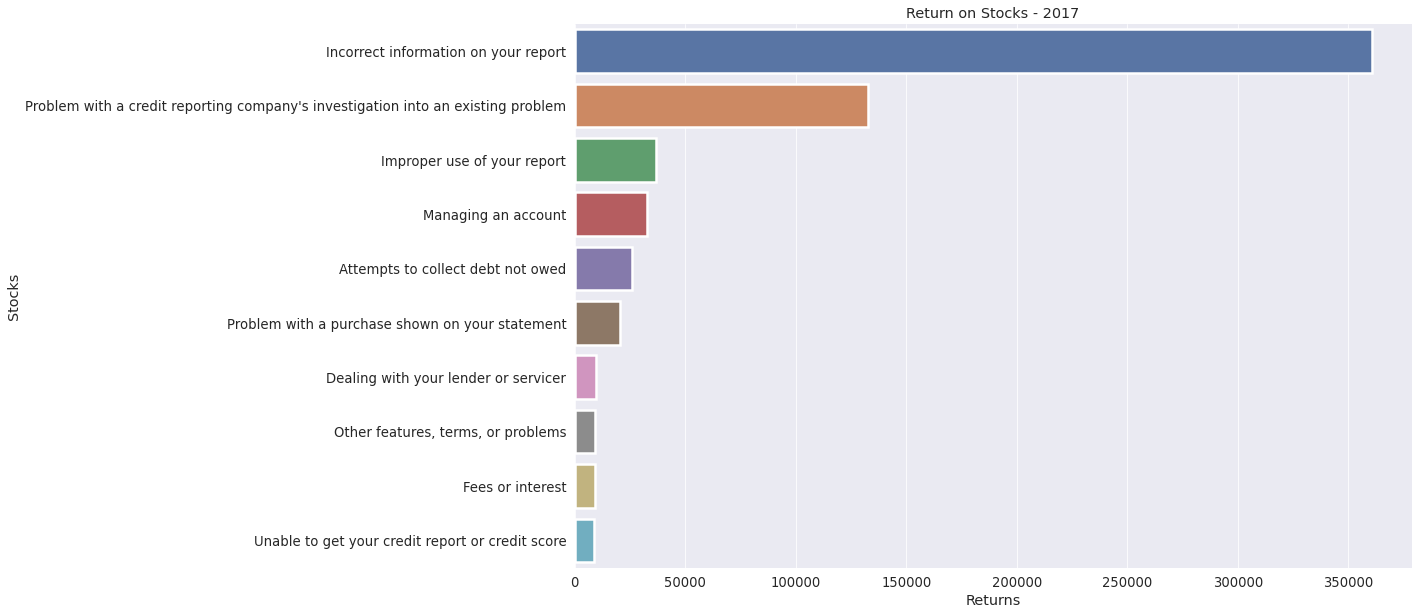

In [30]:
df = shortlist_1[['complaint_id', 'issue']].groupby(['issue']).count()\
.sort_values(by='complaint_id', ascending=False).head(10).reset_index()

sns.set_theme()
sns.set_context("paper", font_scale=1.5)
fig, ax = plt.subplots(figsize=(15, 10))
g = sns.barplot(data=df, x='complaint_id', y="issue",
                linewidth=2.5)
g.set(xlabel='Returns', ylabel='Stocks', title='Return on Stocks - 2017')
sns.despine(left=True, bottom=True)